# Importing the libraries

In [1]:
import pandas as pd 
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
# Comment to make plotly graphs interactive
pio.renderers.default = "svg" # to make graphs visible on github
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor') # To use GPU on pytorch
    device = 'cuda'
else:
    device = 'cpu'

# Stock processing

In [2]:
class Stock(object):
    def __init__(self, ticker: str, timesteps: int, 
                 date_from = dt.datetime(year = 1994, month = 1, day = 1),
                 date_to = dt.datetime.today()):
        
        self.ticker = ticker.upper()
        self.timesteps = timesteps # as days
        self.date_from = date_from
        self.date_to = date_to
        self.mms = MinMaxScaler(feature_range = (0, 1))
            
    def get_data(self):
        """
        Takes the ticker (a string) from Yahoo Finance,
        Adjusts interval to daily, 
        Returns a pandas dataframe with ticker's stock data. 
        """
        interval = "1d"
        period1 = int(self.date_from.timestamp())
        period2 = int(self.date_to.timestamp())
        url = (
                f"https://query1.finance.yahoo.com/v7/finance/download/"
                f"{self.ticker}?period1={period1}&period2={period2}&interval={interval}&events=history"
              )
        dataset = pd.read_csv(url).dropna()
        return dataset
    
    def __split_data(self):
        
        self.df = self.get_data()
        self.train_data = self.df.iloc[:int(self.df.shape[0]*0.7), :] # %70 of the data
        self.test_data = self.df.iloc[int(self.df.shape[0]*0.7):, :] # 30 of the data
    
    def __batch_train_data(self):
        
        # Take training_set with Open data and scale for RNN
        training_set = self.train_data.iloc[:, 1:2].values # 2D array
        training_set_scaled = self.mms.fit_transform(training_set)
        # Create a data with 'timesteps' and 1 output
        t, N = self.timesteps, training_set.shape[0]
        X_train, y_train = [], []
        for i in range(t, N):
            X_train.append(training_set_scaled[i-t:i, 0])
            y_train.append(training_set_scaled[i, 0])
        self.y_train = np.array(y_train).reshape((len(y_train), 1)) #2D Array
        # Reshape X_train for RNN (batch_size, timesteps, input_dim)
        X_train = np.array(X_train)
        self.X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    def __batch_test_data(self):
        
        # Get all 'Open' data from the dataset
        open_data = self.df.iloc[:, 1]
        # Create the inputs to take test_data + 'timesteps' days before
        inputs = open_data[len(open_data) - len(self.test_data) - self.timesteps:].values
        inputs = inputs.reshape(-1, 1)
        # Scale the inputs for prediction
        inputs = self.mms.transform(inputs)
        # Creating a test data with 'timesteps'
        t, N = self.timesteps, inputs.shape[0]
        X_test = []
        for i in range(t, N):
            X_test.append(inputs[i-t:i, 0])
        X_test = np.array(X_test)
        # Reshape X_test for RNN
        self.X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        self.y_test = self.test_data.iloc[:, 1].values.reshape(len(X_test), 1) #2D array
        
    def __tensorize(self):
        self.X_train = torch.from_numpy(self.X_train).to(device = device, dtype = torch.float)
        self.X_test = torch.from_numpy(self.X_test).to(device = device, dtype = torch.float)
        self.y_train = torch.from_numpy(self.y_train).to(device = device, dtype = torch.float)
        self.y_test = torch.from_numpy(self.y_test).to(device = device, dtype = torch.float)
    
    def process(self):
        
        # Get the data
        self.__split_data()
        self.__batch_train_data()
        self.__batch_test_data()
        self.__tensorize()
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def visualize(self, y_pred, stock_name = ''):
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(x = self.df['Date'], y = self.df['Open'],
                        mode = 'lines',
                        name = 'Real Stock Price'))

        fig.add_trace(go.Scatter(x = self.test_data['Date'], y = y_pred, #1D Array
                        mode = 'lines',
                        name = 'Predicted Stock Price'))
        
        fig.update_layout(template = "simple_white", title = stock_name  + ' Stock Price Prediction', 
                  xaxis_title='Time',
                  yaxis_title='Stock Price ($)')
        
        fig.show()

# LSTM Algorithm 

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_dim = 1, 
                       hidden_dim = 32, 
                       num_layers = 2, 
                       output_dim = 1):
        
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

model = LSTM()
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model

In [4]:
data = Stock('TWTR', timesteps = 60)
X_train, X_test, y_train, y_test =  data.process()

In [5]:
num_epochs = 100
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

# Predictions and results

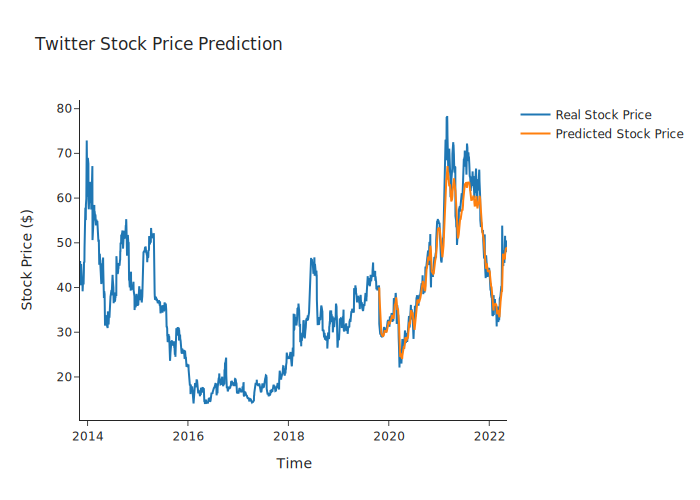

In [6]:
y_test_pred = model(X_test)
y_pred = data.mms.inverse_transform(y_test_pred.to(device = 'cpu').detach().numpy())
data.visualize(y_pred.ravel(), stock_name = 'Twitter')